# ch5. 誤差逆伝播法
誤差逆伝播法における学習アルゴリズム、手書き数字認識の実装

---

## 誤差逆伝播とは

SGDに代わり高速に勾配を求めるのが**誤差逆伝播法**である．   
これは、出力から勾配を求める数式をあらかじめ求めておくという方法である。  


計算グラフ(computional graph)で考える．

<img src="image\computional_graph.jpg" width="200"/>  

各ノードは信号$x$に対して関数$f$によって信号$y=f(x)$を順方向（右方向）に伝搬する．  
これらの関係を逆方向の向きについて考えると，信号$E$に対して，$x$に対する$y$の微分を掛けた$E\frac{\partial y}{\partial x}$が伝搬される．

これらのノードが複数重なったものを考える．

<img src="image\computional_graph2.jpg" width="350"/>  

逆伝播の信号は偏微分の積で表すことができ，簡単化できる．これを連鎖率と呼ぶ．

\begin{equation}
    \frac{\partial z}{\partial z} \frac{\partial z}{\partial t} \frac{\partial t}{\partial x} = \frac{\partial z}{\partial x}
\end{equation}


## 乗算レイヤ

連鎖率を適用すれば，2つの信号を掛け合わせる乗算レイヤはこのようになる．$L$は最終の出力である．

<img src="image\mul_layer.jpg" width="250"/>

これをPythonで実装する．

In [1]:
class MulLayer:
    def __init_(self):
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y        
        return out
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x        
        return dx, dy

## 加算レイヤ

同様に加算レイヤも実装できる．

<img src="image\add_layer.jpg" width="250"/>

In [2]:
class AddLayer:
    def __init_(self):
        pass   #do nothing
        
    def forward(self, x, y):
        out = x + y        
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1        
        return dx, dy

## ReLUレイヤ

ReLUによるレイヤを考える．

\begin{equation}y= \left \{\begin{array}{l}x& (x>0) \\0& (x\leqq0) \\\end{array}\right.\end{equation}

\begin{equation}\frac{\partial y}{\partial x}= \left \{\begin{array}{l}1& (x>0) \\0& (x\leqq0) \\\end{array}\right.\end{equation}

In [3]:
class ReluLayer:
    def __init_(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0    #numpyにおけるマスク処理(Trueのみに適用)
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout        
        return dx

## Sigmoidレイヤ

Sigmoidレイヤについて考える

\begin{equation}
    y=\frac{1}{1+\exp(-x)}
\end{equation}
  
\begin{eqnarray*}
    \frac{\partial y}{\partial x}&=&\frac{1}{1+\exp(-x)}\frac{1}{\exp(x)+1}\\
    &=&y(1-y)
\end{eqnarray*}

In [4]:
class SigmoidLayer:
    def __init_(self):
        self.mask = None
        
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

## Affineレイヤ

ニューラルネットワークの順伝播で行われる，重み付き信号の総和を求める処理を行う．行列の内積をアフィン(affine)変換と呼ぶので，この処理を行うレイヤをAffineレイヤと呼ぶ．

Affineレイヤで行われる処理はこのようなものだった．

\begin{equation} {\bf Y}={\bf X}\cdot{\bf W}+{\bf B} \end{equation}

${\bf W}$は重み，${\bf B}$はバイアスである，行列の内積の処理と加算の処理に分ける．

${\bf Y}={\bf X}\cdot{\bf W}$において，

\begin{equation}\frac{\partial {\bf Y}}{\partial {\bf X}}= {\bf W}^T \end{equation}

${\bf W}^T$は${\bf W}$の転置である．

${\bf Y}={\bf X}+{\bf B}$において，

\begin{equation}\frac{\partial {\bf Y}}{\partial {\bf X}}= 1 \end{equation}

これは加算レイヤと同じとわかる．

バッチ対応して実装する．

In [5]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dw = None
        self.db = None
    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.dB = np.sum(dout, axis = 0)
        return dx

## Softmax-with-Lossレイヤ

出力を正規化するためのソフトマックス関数と，交差エントロピー誤差の計算をあわせたSoftmax-with-Lossレイヤを実装する．

<img src="image\softmax_loss_layer.jpg" width="450"/>

In [6]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backword(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

# 実装
誤差逆伝播法による最終型の実装

誤差逆伝播法で以下の操作を実装する．

1. Mini-Batch  
    訓練データの中からランダムに一部のデータを抽出する．
2. Gradient  
    ミニバッチの損失関数を減らすために，各重みパラメータの勾配を求める．
3. Update Parameters  
    重みパラメータを勾配方向に微小量だけ更新する．  
4. Repeat  
    1～3を繰り返す．

In [7]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        self.layers = OrderedDict()    #順番付きディクショナリ
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = ReluLayer()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t,axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads
    
    def gradient(self, x, t):
        #forward
        self.loss(x, t)
        #backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads

実際に学習ができているか確認する．  
エポックとは，学習において訓練データをすべて見た回数を表し，10000個の訓練データを100個のミニバッチで学習する場合，100試行回数=1エポックとなる．
ここでは1エポックごとに正確さを記録する．また，実行時間も計測する．

In [8]:
from dataset.mnist import load_mnist
import time

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
lerning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(int(train_size / batch_size), 1) #1エポックにあたる試行回数の算出

In [9]:
tic = time.time()
from tqdm import tqdm # プログレスバーを表示するパッケージ

for i in tqdm(range(iters_num)):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    #誤差逆伝搬法で勾配を求める
    grad = network.gradient(x_batch, t_batch)
    
    #更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= lerning_rate * grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    #エポックごとの精度記録
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
toc = time.time()

print("精度: {0}%".format(network.accuracy(x_test, t_test) * 100))
print("実行時間: {0}秒".format(toc - tic))

100%|██████████| 10000/10000 [00:51<00:00, 195.70it/s]


精度: 96.88%
実行時間: 51.11491060256958秒


SGDのとき(同じ試行回数で換算すると339時間)と比べて、格段に早くなった

---

エポックごとの交差エントロピー誤差、精度をプロットする

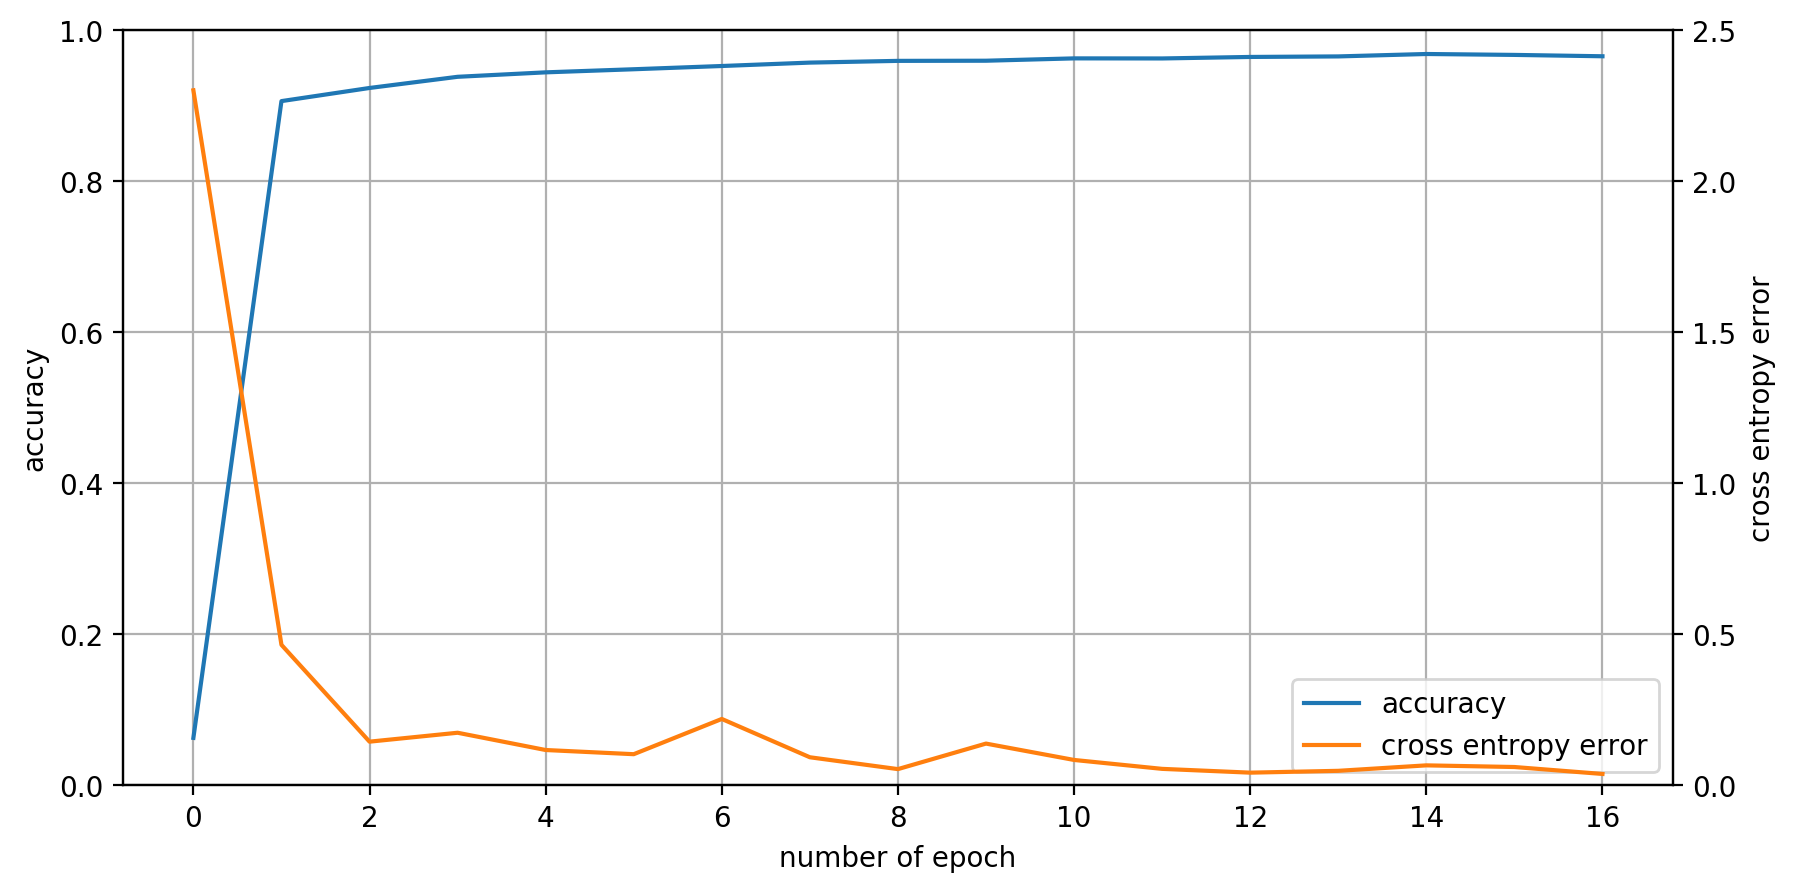

In [10]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi'] = 100

fig = plt.figure()
ax_acc = fig.subplots()
ln_acc = ax_acc.plot(test_acc_list, 'C0', label="accuracy")

ax_loss = ax_acc.twinx()
ln_loss = plt.plot(train_loss_list[::iter_per_epoch], 'C1', label="cross entropy error")

h_acc, l_acc = ax_acc.get_legend_handles_labels()
h_loss, l_loss = ax_loss.get_legend_handles_labels()
ax_acc.legend(h_acc+h_loss, l_acc+l_loss)

ax_acc.set_xlabel('number of epoch')
ax_acc.set_ylabel('accuracy')
ax_acc.set_ylim(0, 1)
ax_acc.grid(True)
ax_loss.set_ylabel('cross entropy error')
ax_loss.set_ylim(0, 2.5)

plt.show()

学習データの精度と、テストデータの精度を比較する

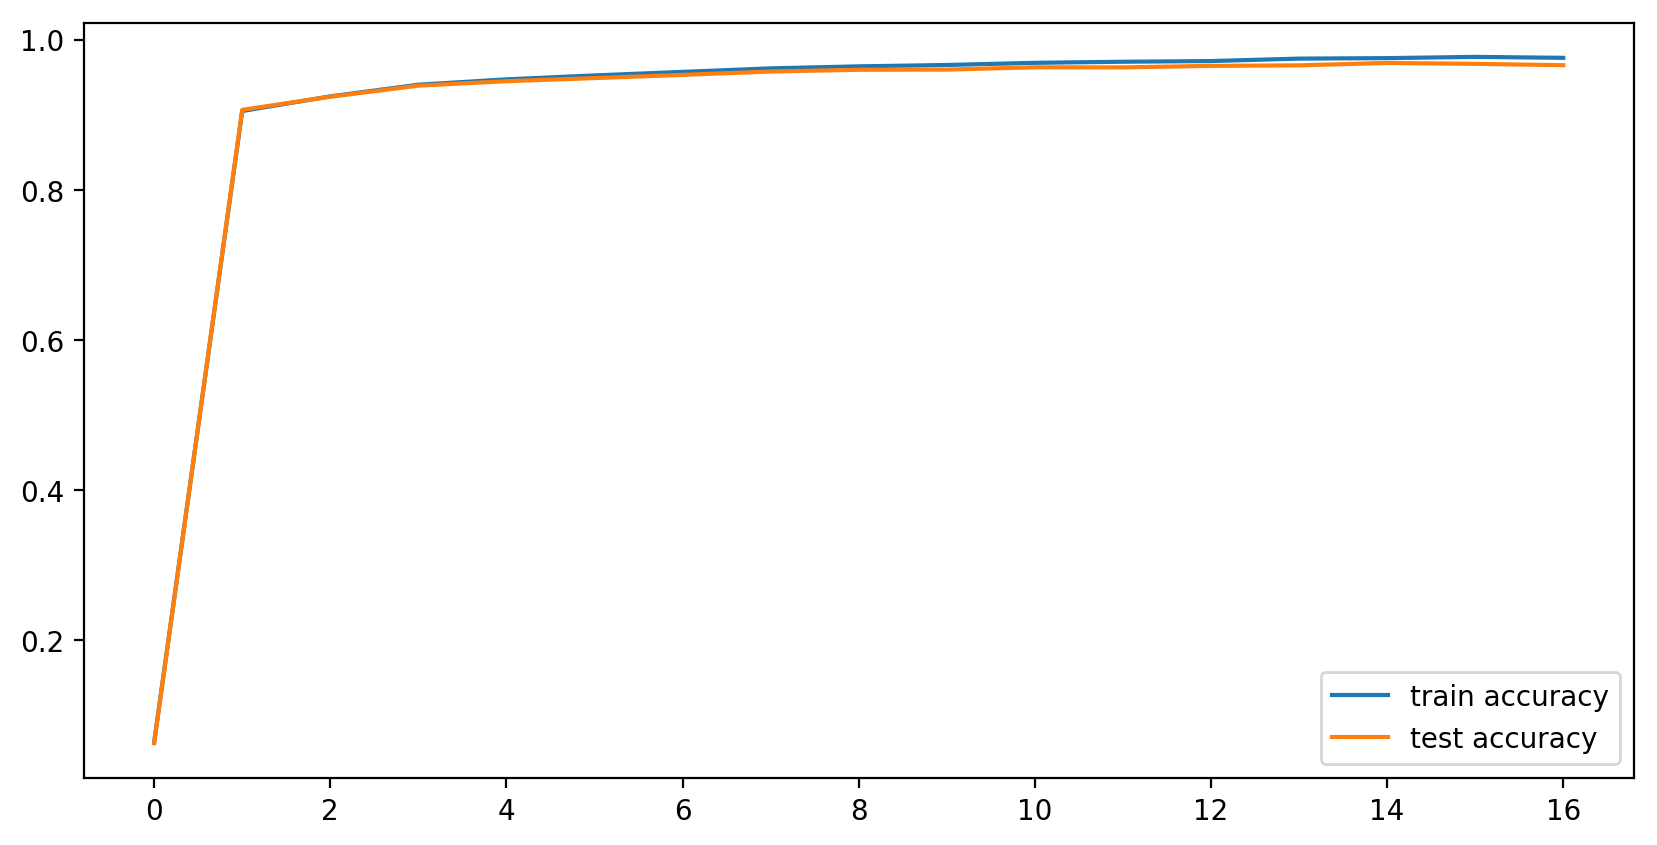

In [16]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi'] = 100

plt.plot(train_acc_list, label="train accuracy")
plt.plot(test_acc_list, label="test accuracy")
plt.legend()

実際の画像データと、正解ラベル、予測値を表示

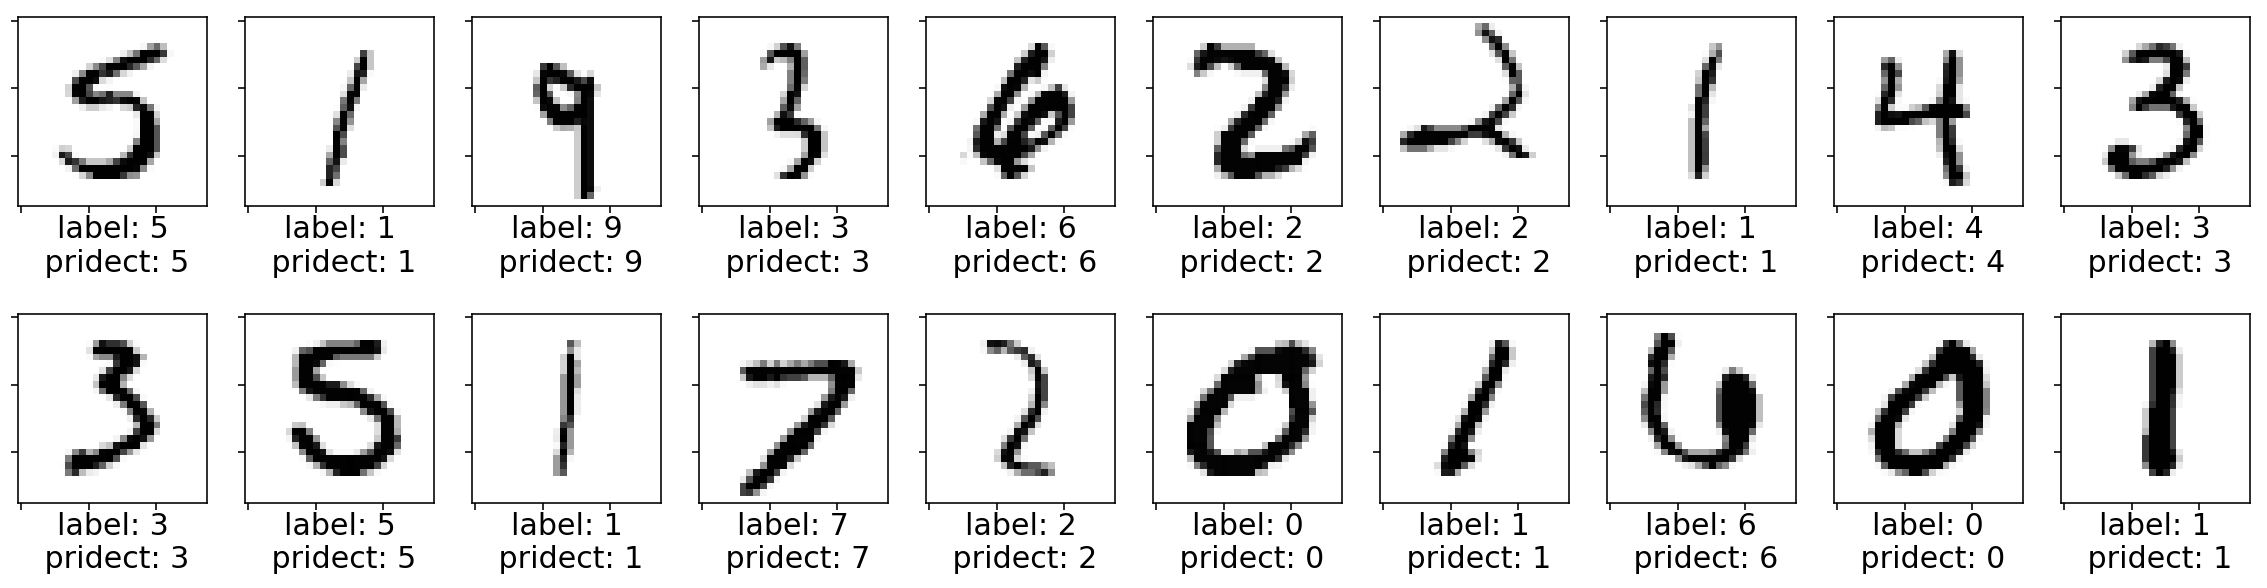

In [12]:
from matplotlib import cm

plt.subplots(2,10,figsize=(20, 5))    #2×10枚の画像を20×5のキャンバス内に展開

for i in range(20):
    img_index = np.random.randint(x_test.shape[0])
    img = x_test[[img_index]]    #imgに各画像が入る
    label = np.argmax(t_test[img_index])
    response = np.argmax(network.predict(img)) #NNによる答え
    
    plt.subplot(2, 10, i + 1)
    plt.tick_params(which='both',labelleft='off', labelbottom='off')    #軸の数字を消す
    plt.xlabel("label: {0}\n pridect: {1}".format(label, response), fontsize=15)    #ラベルを図の下に表示
    
    img = img.reshape(28, 28)    #1次元配列を2次元配列に直す
    plt.imshow(img, cmap = cm.Greys)    #白黒画像で表示

予測を間違えた画像を表示

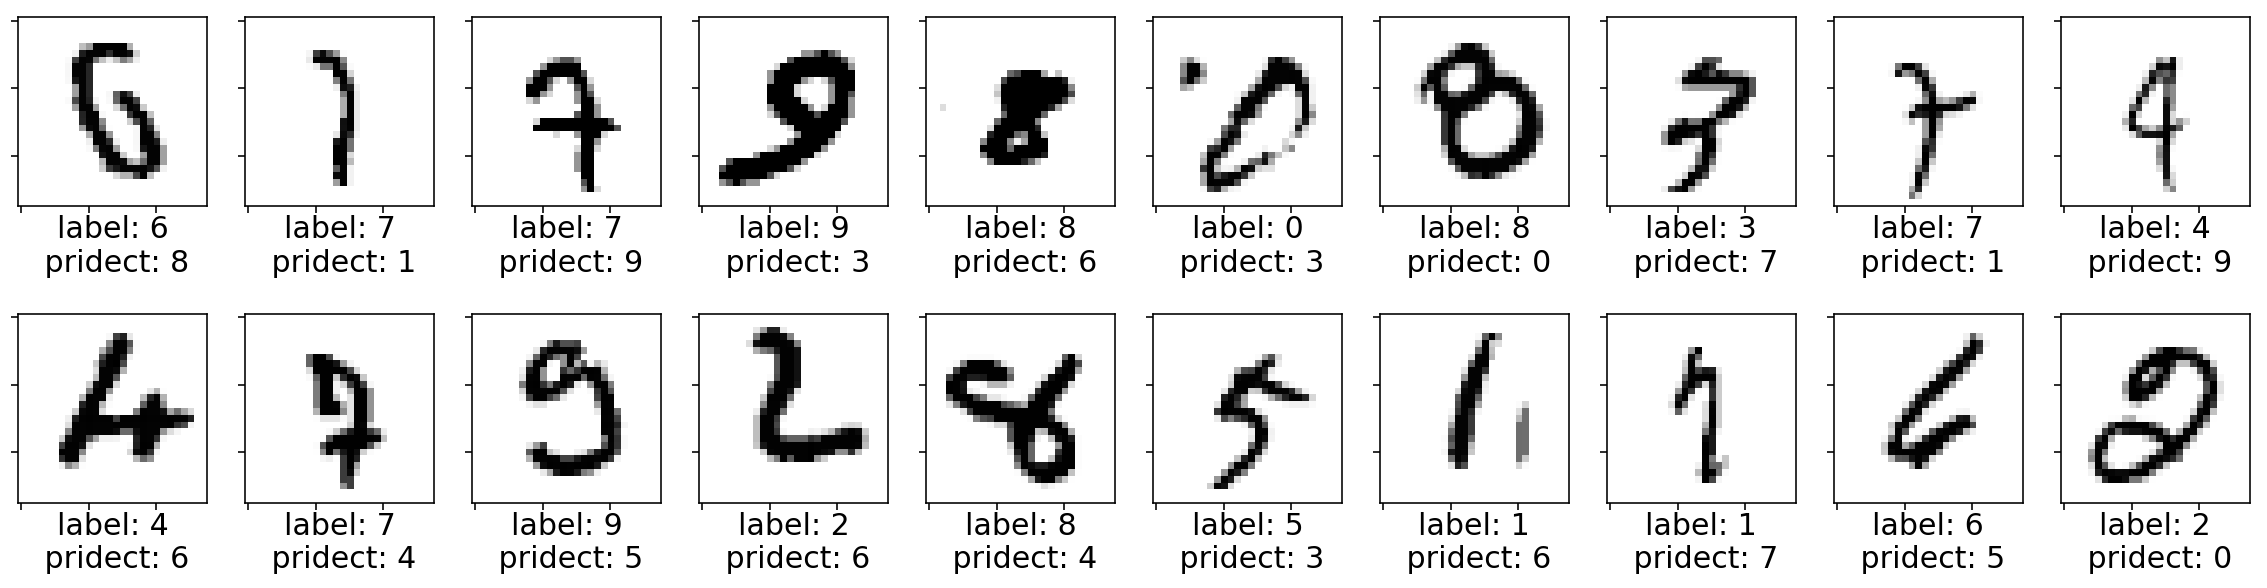

In [13]:
label = np.argmax(t_test, axis=1)
predict = np.argmax(network.predict(x_test), axis=1)

# 間違えた画像のインデックスのリスト
miss_index = np.arange(t_test.shape[0])[label != predict]
choice_index = np.random.choice(miss_index, 20)

plt.subplots(2,10,figsize=(20, 5))

for i, img_index in enumerate(choice_index):
    img = x_test[[img_index]]    #imgに各画像が入る
    label = np.argmax(t_test[img_index])
    response = np.argmax(network.predict(img)) #NNによる答え
    
    plt.subplot(2, 10, i + 1)
    plt.tick_params(which='both',labelleft='off', labelbottom='off')    #軸の数字を消す
    plt.xlabel("label: {0}\n pridect: {1}".format(label, response), fontsize=15)    #ラベルを図の下に表示
    
    img = img.reshape(28, 28)    #1次元配列を2次元配列に直す
    plt.imshow(img, cmap = cm.Greys)    #白黒画像で表示